# MNIST

This tutorial demonstrates how to build a simple diffusion model with Azula, and train it to generate MNIST images.

In [1]:
# !pip install datasets

In [2]:
import torch
import torch.nn as nn

from datasets import load_dataset
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision.utils import make_grid
from tqdm import tqdm

from azula.denoise import KarrasDenoiser
from azula.nn.unet import UNet
from azula.noise import VPSchedule
from azula.sample import DDIMSampler

device = "cuda"

## Data

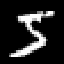

In [3]:
def transform(rows):
    rows["image"] = list(map(to_tensor, rows["image"]))
    rows["label"] = list(map(torch.as_tensor, rows["label"]))
    return rows


dataset = load_dataset("mnist", split="train", keep_in_memory=True)
dataset = dataset.with_transform(transform)

to_pil_image(dataset[0]["image"]).resize((64, 64), Image.NEAREST)

In [4]:
def preprocess(x):
    return 2 * x - 1

In [5]:
def postprocess(x):
    return torch.clip((x + 1) / 2, min=0, max=1)

## Diffusion model

In [6]:
class UNetWrapper(nn.Module):
    def __init__(self, channels: int = 1, emb_features: int = 64):
        super().__init__()

        self.unet = UNet(
            in_channels=channels,
            out_channels=channels,
            hid_channels=[16, 32, 64],
            hid_blocks=[2, 2, 2],
            mod_features=emb_features,
        )

        self.label_embedding = nn.Embedding(10, emb_features)
        self.time_embedding = nn.Sequential(
            nn.Linear(1, emb_features),
            nn.SiLU(),
            nn.Linear(emb_features, emb_features),
        )

    def forward(self, x_t, log_snr_t, label):
        emb = self.label_embedding(label) + self.time_embedding(log_snr_t[..., None])
        x_0 = self.unet(x_t, emb)
        return x_0


denoiser = KarrasDenoiser(backbone=UNetWrapper(), schedule=VPSchedule()).to(device)

## Training

In [7]:
optimizer = torch.optim.Adam(denoiser.parameters(), lr=3e-4)

In [8]:
loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    num_workers=2,
)

for _ in (bar := tqdm(range(16), ncols=79, ascii=True)):
    losses = []

    for batch in loader:
        x = batch["image"].to(device=device)
        label = batch["label"].to(device=device)

        x = preprocess(x)
        t = torch.rand(len(x), device=device)

        loss = denoiser.loss(x, t, label=label)
        loss.backward()
        losses.append(loss.detach())

        optimizer.step()
        optimizer.zero_grad()

    bar.set_postfix(loss=torch.stack(losses).mean().item())

100%|##############################| 16/16 [09:02<00:00, 33.88s/it, loss=0.153]


## Evaluation

100%|#######################################| 64/64 [00:00<00:00, 101.66step/s]


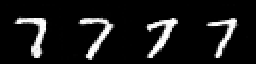

In [9]:
sampler = DDIMSampler(denoiser, steps=64)

label = torch.tensor(7, device=device)

x1 = sampler.init((4, 1, 28, 28), device=device)
x0 = sampler(x1, label=label)

to_pil_image(make_grid(postprocess(x0))).resize((256, 64), Image.NEAREST)